In [1]:
# Initialize GPU
import pyclesperanto_prototype as cle
import beetlesafari as bs
import numpy as np

cle.select_device('RTX')

C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\magicgui\widgets\_bases.py:558: FutureWarning: The 'maximum' keyword arguments has been changed to 'max'. In the future this will raise an exception

  warnings.warn(
C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\magicgui\widgets\_bases.py:558: FutureWarning: The 'minimum' keyword arguments has been changed to 'min'. In the future this will raise an exception

  warnings.warn(


<Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

In [2]:
%gui qt

In [3]:
# convenience methods
def show(image, labels=False, title=None, use_napari=False):
    if len(image.shape) == 3:
        # print(image.shape)
        max_projection = cle.create([image.shape[1], image.shape[2]])
        cle.maximum_z_projection(image, max_projection)
        cle.imshow(cle.transpose_xy(max_projection), labels=labels, min_display_intensity=0)
    else:
        cle.imshow(cle.transpose_xy(image), labels=labels, min_display_intensity=0)    
    
    if use_napari:
        if labels:
            show.viewer.add_labels(cle.pull_zyx(image), name=title)
        else:
            show.viewer.add_image(cle.pull_zyx(image), name=title)

import napari

# create Qt GUI context
napari.gui_qt()        
show.viewer = napari.Viewer()

from napari_pyclesperanto_assistant import napari_plugin
napari_plugin(show.viewer)

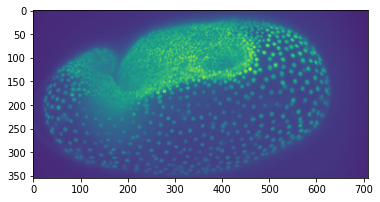

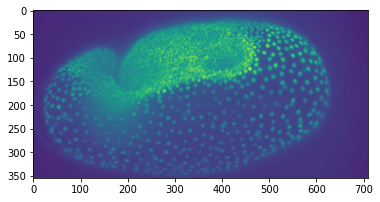

In [4]:
# Configure data source
path = 'C:/structure/data/2019-12-17-16-54-37-81-Lund_Tribolium_nGFP_TMR/stacks/C0opticsprefused/'
filename_1 = path + '001200.raw'
filename_2 = path + '001201.raw'
width = 512
height = 1024
depth = 71
voxel_size = [3, 0.6934, 0.6934]

# load and resample
def load_and_resample(filename, width, height, depth, voxel_size):
    img_arr = bs.imread_raw(filename, width, height, depth)
    buffer = cle.push_zyx(img_arr)
    return cle.resample(buffer, factor_x = voxel_size[2], factor_y = voxel_size[1], factor_z = voxel_size[0])

input_image = load_and_resample(filename_1, width, height, depth, voxel_size)
other_image = load_and_resample(filename_2, width, height, depth, voxel_size)
    
show(input_image, title="original", use_napari=True)
show(other_image, title="next timepoint", use_napari=True)

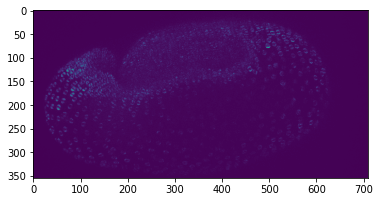

In [5]:
# determine local changes
difference_image = cle.squared_difference(input_image, other_image)
show(difference_image, title="difference between timepoints", use_napari=True)

# Segmentation

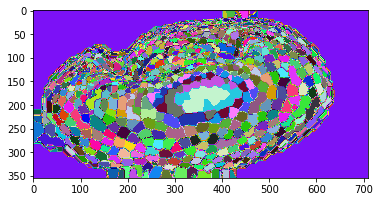

next timepoint:


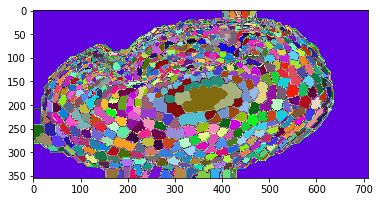

In [6]:
cells, spots = bs.segmentation(input_image)
show(cells, labels=True)
print("=======================================\nnext timepoint:")
other_cells, other_spots = bs.segmentation(other_image)
show(other_cells, labels=True)

# Quantiative analysis
## Neighbors and distances

(1790, 1790)


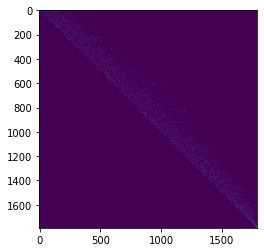

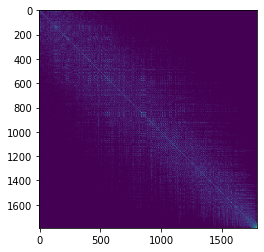

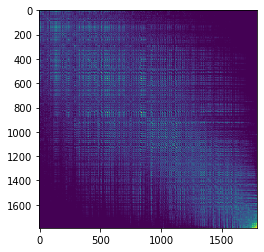

In [7]:
# determine neighbors of cells
touch_matrix = cle.generate_touch_matrix(cells)

# ignore touching the background
cle.set_column(touch_matrix,0,0)
cle.set_row(touch_matrix,0,0)

print(touch_matrix.shape)
show(touch_matrix)

# determine neighbors of neigbors
neighbors_of_neighbors = cle.neighbors_of_neighbors(touch_matrix)
show(neighbors_of_neighbors)

# determine neighbors of neighbors of neighbors
neighbors_of_neighbors_of_neighbors = cle.neighbors_of_neighbors(neighbors_of_neighbors)
show(neighbors_of_neighbors_of_neighbors)

pointlist (3, 1789)


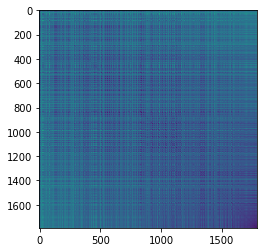

In [8]:
# determine distances of all cells to all cells
pointlist = cle.centroids_of_labels(cells)
print("pointlist", pointlist.shape)
distance_matrix = cle.generate_distance_matrix(pointlist, pointlist)
show(distance_matrix)

## Estimate displacement

other_pointlist (3, 1808)
displacement_matrix (1790, 1809)
displacement_vector (1, 1790)


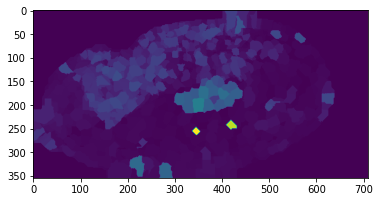

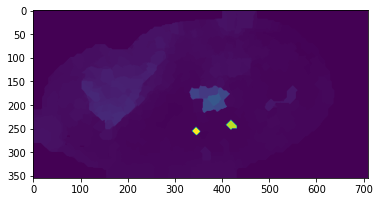

In [9]:
# determine closest distances over time; a simple displacement estimation
other_pointlist = cle.centroids_of_labels(other_cells)
print("other_pointlist", other_pointlist.shape)
displacement_matrix = cle.generate_distance_matrix(pointlist, other_pointlist)
print("displacement_matrix", displacement_matrix.shape)

displacement_vector = cle.average_distance_of_n_closest_points(displacement_matrix)
print("displacement_vector", displacement_vector.shape)

displacement_map = cle.replace_intensities(cells, displacement_vector)
show(displacement_map, title="distance map", use_napari=True)

displacement_map = cle.replace_intensities(cells, cle.median_of_touching_neighbors(displacement_vector,neighbors_of_neighbors))
show(displacement_map, title="local median distance map", use_napari=True)

## Measure average neigbor distance

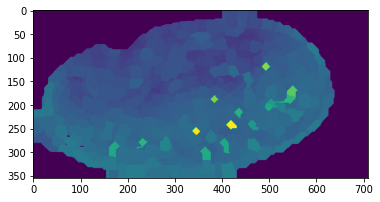

In [10]:
nearest_neighbor_distance = cle.average_distance_of_n_closest_points(distance_matrix, n=6)

nn_distance_map = cle.replace_intensities(cells, nearest_neighbor_distance)
show(nn_distance_map, title="distance map", use_napari=True)

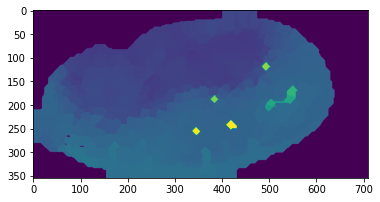

In [11]:
local_nearest_neighbor_distance = cle.median_of_touching_neighbors(nearest_neighbor_distance, neighbors_of_neighbors)

nn_distance_map = cle.replace_intensities(cells, local_nearest_neighbor_distance)
show(nn_distance_map, title="local median distance map", use_napari=True)

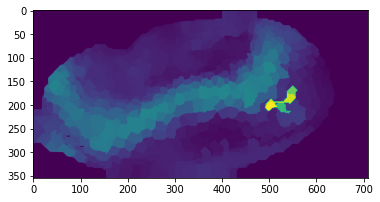

In [12]:
local_stddev_nearest_neighbor_distance = cle.standard_deviation_of_touching_neighbors(local_nearest_neighbor_distance, neighbors_of_neighbors)

nn_distance_map = cle.replace_intensities(cells, local_stddev_nearest_neighbor_distance)
show(nn_distance_map, title="local stddev average distance map", use_napari=True)

## Measure neighbor count

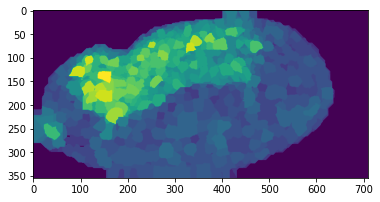

In [13]:
touching_neighbor_count = cle.count_touching_neighbors(touch_matrix)
cle.set_column(touching_neighbor_count, 0, 0)

tnc_map = cle.replace_intensities(cells, touching_neighbor_count)
show(tnc_map, title="neighbor count", use_napari=True)

[[ 0. 10.  9. ...  7.  6.  7.]]


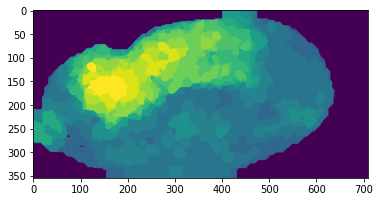

In [14]:
local_touching_neighbor_count = cle.median_of_touching_neighbors(touching_neighbor_count, touch_matrix)

print(local_touching_neighbor_count)
tnc_map = cle.replace_intensities(cells, local_touching_neighbor_count)
show(tnc_map, title="local median neighbor count", use_napari=True)

## Measurements

In [31]:
print("Number of cells", cle.maximum_of_all_pixels(cells))
regionprops = cle.statistics_of_background_and_labelled_pixels(input_image, cells)
print("Number of measurements per cell", len(regionprops))

Number of cells 1789.0
Number of measurements per cell 40


These are the measurements we can use further down:

In [30]:
print(regionprops.keys())

dict_keys(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z', 'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height', 'bbox_depth', 'bbox', 'min_intensity', 'max_intensity', 'sum_intensity', 'area', 'mean_intensity', 'sum_intensity_times_x', 'mass_center_x', 'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z', 'mass_center_z', 'weighted_centroid', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z', 'centroid_z', 'centroid', 'sum_distance_to_centroid', 'mean_distance_to_centroid', 'sum_distance_to_mass_center', 'mean_distance_to_mass_center', 'standard_deviation_intensity', 'max_distance_to_centroid', 'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio', 'mean_max_distance_to_mass_center_ratio'])


## Measure size

[[   0. 1770. 3578. ... 8486. 7314. 7980.]]


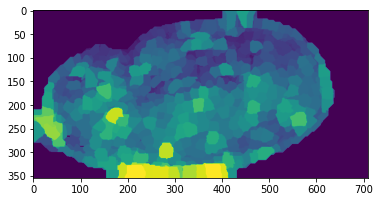

In [32]:
size = cle.push(np.asarray([regionprops['area']]))

# ignore background
cle.set_column(size, 0, 0)

print(size)
size_map = cle.replace_intensities(cells, size)
show(size_map, title="size", use_napari=True)

## Measure mean intensity

[[  0.      506.45593 520.4715  ... 267.60345 234.75485 248.01628]]


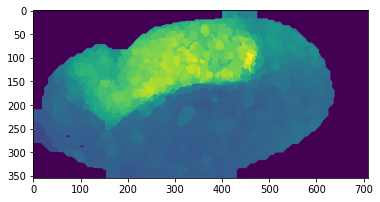

In [33]:
intensity = cle.push_zyx(np.asarray([regionprops['mean_intensity']]))

# ignore background
cle.set_column(intensity, 0, 0)

print(intensity)
intensity_map = cle.replace_intensities(cells, intensity)
show(intensity_map, title="intensity", use_napari=True)

## Measure standard_deviation intensity

[[  0.      506.45593 520.4715  ... 267.60345 234.75485 248.01628]]


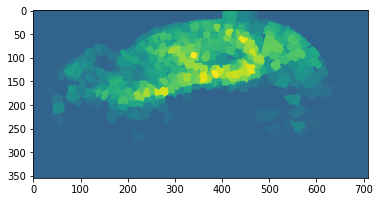

In [25]:
standard_deviation_intensity = cle.push(np.asarray([regionprops['standard_deviation_intensity']]))

# ignore background
cle.set_column(intensity, 0, 0)

print(intensity)
intensity_map = cle.replace_intensities(cells, standard_deviation_intensity)
show(intensity_map, title="intensity", use_napari=True)

## Measure major_axis_length

[[ 0.       16.78533  18.693167 ... 20.202263 17.854944 18.112621]]


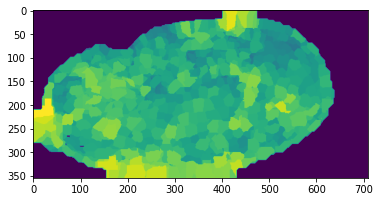

In [34]:

major_axis_length = cle.push(np.asarray([regionprops['max_distance_to_centroid']]))

# ignore background
cle.set_column(major_axis_length, 0, 0)

print(major_axis_length)
major_axis_length_map = cle.replace_intensities(cells, major_axis_length)
show(major_axis_length_map, title="major_axis", use_napari=True)

[[ 0.        7.125413  8.488127 ... 10.066326  9.600167  9.906817]]


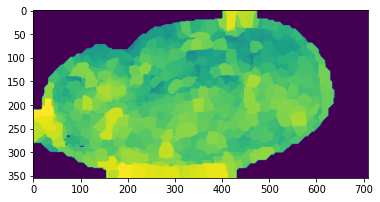

In [36]:
minor_axis_length = cle.push(np.asarray([regionprops['mean_distance_to_centroid']]))

# ignore background
cle.set_column(minor_axis_length, 0, 0)

print(minor_axis_length)
minor_axis_length_map = cle.replace_intensities(cells, minor_axis_length)
show(minor_axis_length_map, title="minor_axis", use_napari=True)

# Plotting

In [37]:
print(nearest_neighbor_distance.shape)
print(touching_neighbor_count.shape)
print(local_stddev_nearest_neighbor_distance.shape)
print(intensity.shape)


(1, 1790)
(1, 1790)
(1, 1790)
(1, 1790)


## Ploting the raw measurements

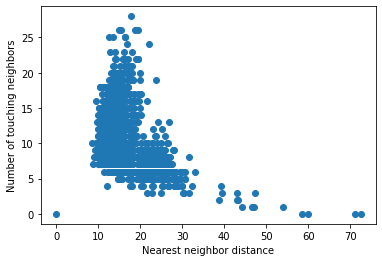

In [38]:
import matplotlib.pyplot as plt

plt.scatter(nearest_neighbor_distance, touching_neighbor_count)
plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

## Plotting the locally averaged measurements

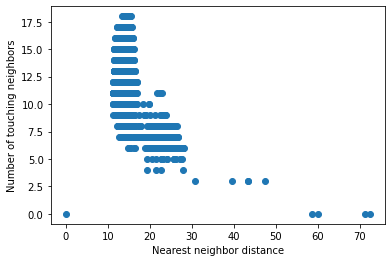

In [39]:
import matplotlib.pyplot as plt

plt.scatter(local_nearest_neighbor_distance, local_touching_neighbor_count)
plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

# Clustering

In [40]:
num_classes = 5

raw_data = [
    size,
    intensity,
    standard_deviation_intensity,
    major_axis_length,
    minor_axis_length,
    touching_neighbor_count,
    displacement_vector,
    cle.average_distance_of_n_closest_points(distance_matrix, n=1),
    cle.average_distance_of_n_closest_points(distance_matrix, n=2),
    cle.average_distance_of_n_closest_points(distance_matrix, n=3),
    cle.average_distance_of_n_closest_points(distance_matrix, n=4),
    cle.average_distance_of_n_closest_points(distance_matrix, n=5),
    cle.average_distance_of_n_closest_points(distance_matrix, n=6),
    cle.average_distance_of_n_closest_points(distance_matrix, n=10),
    cle.average_distance_of_n_closest_points(distance_matrix, n=15),
    cle.average_distance_of_n_closest_points(distance_matrix, n=20),
]

neighborhoods = [touch_matrix, neighbors_of_neighbors, neighbors_of_neighbors_of_neighbors]

preproc_data = []

for element in raw_data:
    #print(element[0].size)
    preproc_data.append(element[0])
    
    for neighborhood in neighborhoods:
    
        median = cle.median_of_touching_neighbors(element, neighborhood)
        preproc_data.append(median[0])
    
        stddev = cle.standard_deviation_of_touching_neighbors(element, neighborhood)
        preproc_data.append(stddev[0])
    
        mean = cle.mean_of_touching_neighbors(element, neighborhood)
        preproc_data.append(mean[0])
    
        minimum = cle.minimum_of_touching_neighbors(element, neighborhood)
        preproc_data.append(minimum[0])

        maximum = cle.maximum_of_touching_neighbors(element, neighborhood)
        preproc_data.append(maximum[0])

data = np.asarray(preproc_data).T
print(data.shape)

(1790, 256)


In [41]:
def show_prediction(cells, prediction, name = "", use_napari=True):
    predicition_vector = cle.push_zyx(np.asarray([prediction]) + 1)

    # set background to 0
    cle.set_column(predicition_vector, 0, 0)
    print(predicition_vector)

    print(prediction)
    print(np.max(prediction))

    prediction_map = cle.replace_intensities(cells, predicition_vector)
    show(prediction_map, title="prediction " + name, use_napari=use_napari)
    
    mode_prediction = cle.mode_of_touching_neighbors(predicition_vector, neighbors_of_neighbors)
    prediction_map = cle.replace_intensities(cells, mode_prediction)
    show(prediction_map, title="prediction" + name, use_napari=use_napari)

## Gaussian mixture model

In [42]:
from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=num_classes, covariance_type='full')
clf.fit(data)
# print(clf.means_, clf.covariances_)

GaussianMixture(n_components=5)

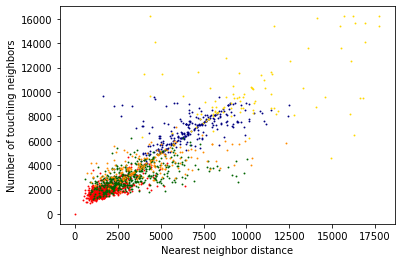

[[0. 2. 3. ... 1. 1. 1.]]
[1 1 2 ... 0 0 0]
4


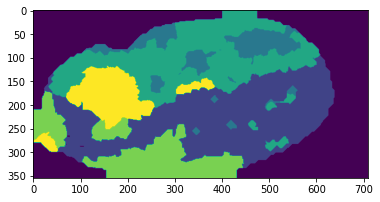

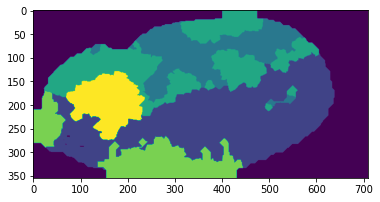

In [43]:
# inspired by https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
color_iter = ['navy', 'red', 'darkgreen', 'gold', 'darkorange']

gmm_prediction = clf.predict(data)

for i in range(clf.n_components):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(data[gmm_prediction == i, 0], data[gmm_prediction == i, 1], .8, color=color)

plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

show_prediction(cells, gmm_prediction, "Gaussian Mixture")

## K-means clustering

[0 0 4 ... 1 1 1]
[[0. 1. 5. ... 2. 2. 2.]]
[0 0 4 ... 1 1 1]
4


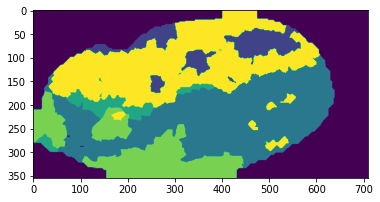

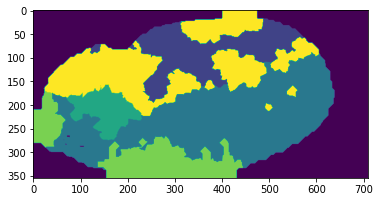

In [44]:
# inspired by https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(data)

kmeans_prediction = kmeans.predict(data)

print(kmeans_prediction)

show_prediction(cells, kmeans_prediction, "K-means clustering")

## MeanShift
https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py

[[0. 1. 1. ... 2. 2. 2.]]
[2 0 0 ... 1 1 1]
2


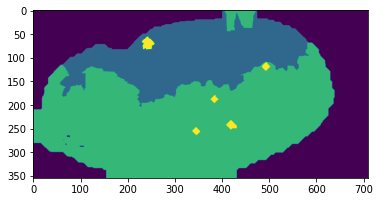

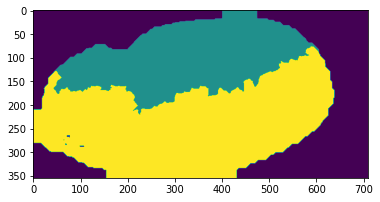

In [45]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data)
ms_prediction = ms.labels_

show_prediction(cells, ms_prediction, "MeanShift")

## AffinityPropagation
https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#sphx-glr-auto-examples-cluster-plot-affinity-propagation-py

C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


[[ 0. 50. 21. ... 71. 71. 70.]]
[16 49 20 ... 70 70 69]
70


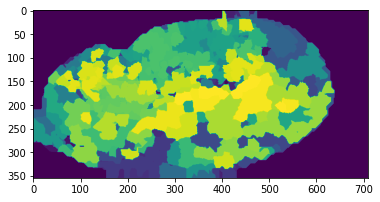

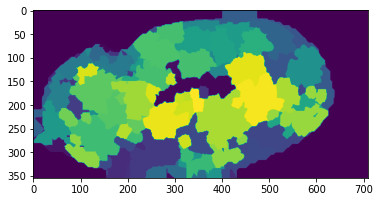

In [46]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation().fit(data)

ap_prediction = ap.labels_

show_prediction(cells, ap_prediction, "AffinityPropagation")

## SpectralClustering

C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\sklearn\utils\validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)
C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


[[0. 1. 2. ... 3. 3. 3.]]
[0 0 1 ... 2 2 2]
4


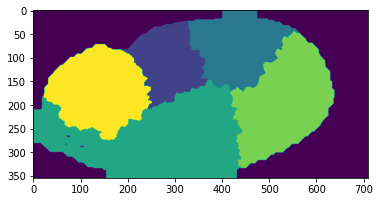

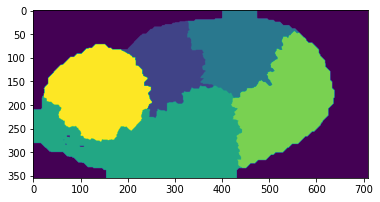

In [47]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(num_classes, affinity='precomputed', n_init=100,
                         assign_labels='discretize')
sc_prediction = sc.fit_predict(cle.pull_zyx(touch_matrix))

show_prediction(cells, sc_prediction, "SpectralClustering")